In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, cohen_kappa_score

In [3]:
import scBalance as sb

## 1. Intra-dataset test (baseline)

Load data and preprocess

In [4]:
adata = sc.read_csv("C:\\Users\Lenovo\\Documents\\Python Scripts\\Intra-dataset\\Pancreatic_data\\Baron Human\\Filtered_Baron_HumanPancreas_data.csv")

In [3]:
label = pd.read_csv('C:\\Users\Lenovo\\Documents\\Python Scripts\\Intra-dataset\\Pancreatic_data\\Baron Human\\Labels.csv')

In [4]:
label

,x
0,acinar
1,acinar
2,acinar
3,acinar
4,acinar
...,...
8564,activated_stellate
8565,alpha
8566,beta
8567,beta


In [6]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

data = adata.to_df()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data, label)

Running scBalance

In [8]:
pred_label = sb.scBalance(X_test, X_train, y_train, processing_unit = 'gpu')

--------Start annotating----------
Computational unit be used is: cuda
100%[====================->]28.94s
--------Annotation Finished----------


Metrics calculation

In [9]:
f1_score(y_test, pred_label,average='micro')

0.9836677554829678

In [10]:
f1_score(y_test, pred_label,average='macro')

0.9312333023134168

In [11]:
from sklearn.metrics import confusion_matrix,cohen_kappa_score
cm = confusion_matrix(y_test, pred_label, labels = list(set(pred_label)))

In [12]:
cohen_kappa_score(y_test,pred_label)

0.9796479437517519

In [190]:
import seaborn as sns
import matplotlib as plt

In [191]:
cm_new = pd.DataFrame(cm_new)

In [192]:
cm_new.columns = list(set(pred_label))

In [193]:
cm_new.index = list(set(pred_label))

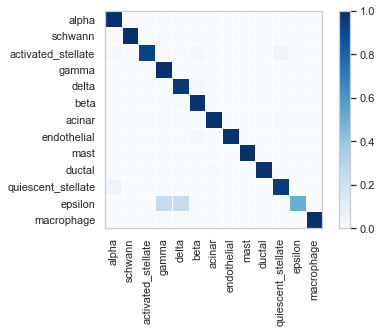

In [199]:
sns.set_theme(style="whitegrid")
a = sns.heatmap(cm_new, cmap= 'Blues', square = True,vmin=0, vmax=1,linewidths=.5)
sns.despine(top = False, right = False, left= False, bottom=False)
eps = a.get_figure()
eps.savefig('baronm.eps',dpi=600)

## 2. Cross-platform annotation

Load dataset and preprocessing

In [3]:
train_adata = sc.read_csv("C:\\Users\\Lenovo\\Documents\\Python Scripts\\Inter-dataset\\PbmcBench\\10Xv3\\10Xv3_pbmc1.csv")
test_adata = sc.read_csv("C:\\Users\\Lenovo\\Documents\\Python Scripts\\Inter-dataset\\PbmcBench\\Smart-seq2\\SM2_pbmc1.csv")

In [4]:
train_label = pd.read_csv("C:\\Users\\Lenovo\\Documents\\Python Scripts\\Inter-dataset\\PbmcBench\\10Xv3\\10Xv3_pbmc1Labels.csv")
test_label = pd.read_csv("C:\\Users\\Lenovo\\Documents\\Python Scripts\\Inter-dataset\\PbmcBench\\Smart-seq2\\SM2_pbmc1Labels.csv")

In [11]:
sc.pp.normalize_total(train_adata, target_sum=1e4)
sc.pp.log1p(train_adata)

sc.pp.normalize_total(test_adata, target_sum=1e4)
sc.pp.log1p(test_adata)

In [13]:
gene = train_adata.var_names & test_adata.var_names

<ipython-input-13-d18f17e890f6>:1: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  gene = train_adata.var_names & test_adata.var_names


In [14]:
X_train = train_adata.to_df()[gene]
X_test = test_adata.to_df()[gene]

In [15]:
y_train = train_label
y_test = test_label

Running scBalance

In [16]:
pred_label = sb.scBalance(X_test, X_train, y_train, processing_unit = 'gpu')

--------Start annotating----------
Computational unit be used is: cuda
100%[====================->]47.30s
--------Annotation Finished----------


In [25]:
len(pred_label)

17873

In [33]:
label = pd.DataFrame(pred_label, columns=['Label'])

In [35]:
label.to_csv("10xv3_label.csv", index=0)

Metrics calculation

In [92]:
f1_score(y_test, pred_label,average='micro')

0.9952345652864556

In [93]:
f1_score(y_test, pred_label,average='macro')

0.747902913694977

In [94]:
confusion_matrix(y_test, pred_label)

array([[2351,    0,    0,    0,    0,    2,    0,    0],
       [   0, 3819,    0,    0,    0,    4,    0,    0],
       [   0,    1,  568,    0,    0,    0,    0,    0],
       [   0,    0,    0, 4383,   50,    0,    0,    0],
       [   0,    1,    0,   26, 6771,    0,    0,    6],
       [   0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,  904,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0]], dtype=int64)

In [95]:
cohen_kappa_score(y_test,pred_label)

0.9936917188261012

In [96]:
from collections import Counter
Counter(pred_label)

Counter({'Cytotoxic T cell': 6821,
         'CD4+ T cell': 4409,
         'Natural killer cell': 6,
         'CD14+ monocyte': 3821,
         'B cell': 2351,
         'Megakaryocyte': 904,
         'CD16+ monocyte': 568,
         'Dendritic cell': 6})

In [150]:
sc.pp.filter_cells(test_adata, min_genes=200)
sc.pp.filter_genes(test_adata, min_cells=3)

In [151]:
test_adata.var['mt'] = test_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(test_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

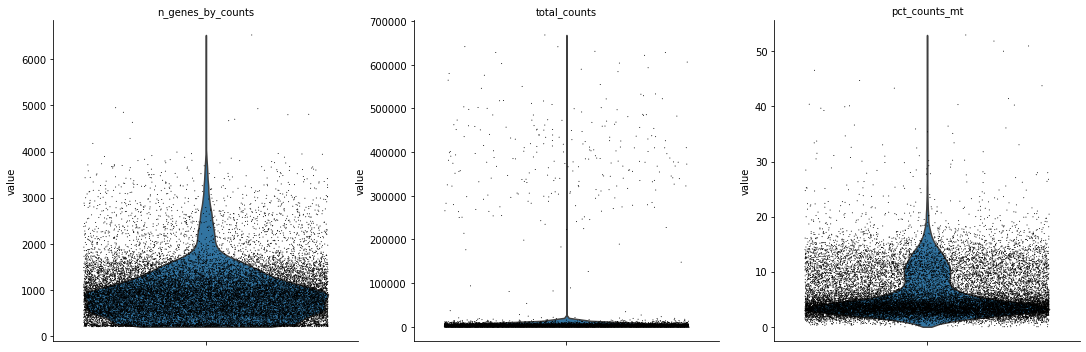

In [152]:
sc.pl.violin(test_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [153]:
test_adata = test_adata[test_adata.obs.n_genes_by_counts < 3000, :]
test_adata = test_adata[test_adata.obs.pct_counts_mt < 17, :]

In [155]:
sc.pp.highly_variable_genes(test_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [156]:
test_adata = test_adata[:, test_adata.var.highly_variable]

In [157]:
sc.tl.pca(test_adata, svd_solver='arpack')

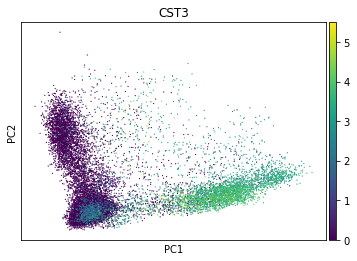

In [158]:
sc.pl.pca(test_adata, color='CST3')

In [159]:
sc.pp.neighbors(test_adata, n_neighbors=10, n_pcs=40)

In [160]:
sc.tl.umap(test_adata)

In [161]:
sc.tl.leiden(test_adata)

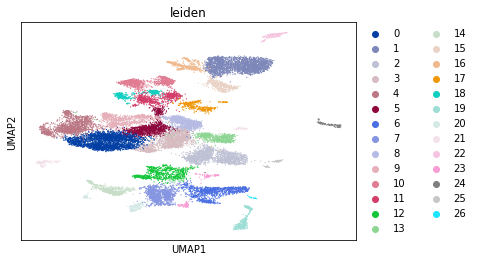

In [162]:
sc.pl.umap(test_adata, color=['leiden'])

In [147]:
test_adata.obs['Label'] = pred_label

D:\anaconda\envs\pytorch\lib\site-packages\anndata\_core\anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Label' as categorical


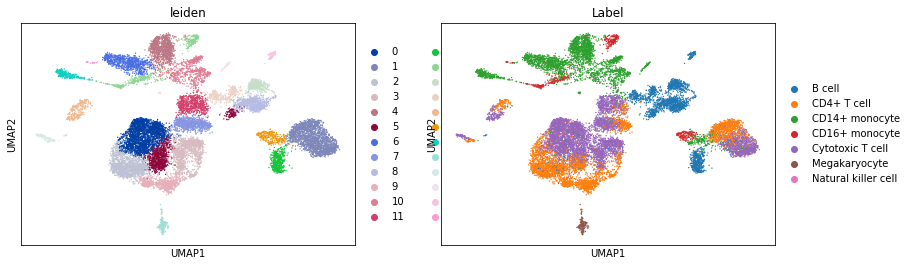

In [148]:
sc.pl.umap(test_adata, color=['leiden','Label'])